## Objective

Our main motive in this section is to optimise our best performing model; Random Forest. For fine tuning the model we will use two cross validation methods provided by sklearn:

* GridSearchCV
* RandomizedSearchCV

__Load necessary libraries__

In [30]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import warnings
# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# display all columns
pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
# load data
df = pd.read_csv("data/data_final.csv",index_col=False)

### Feature Scaling

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.

In [3]:
#create feature (x) and target (y) variables
x = df.drop("Price", axis=1)
Y = df["Price"].copy()

In [4]:
#feature scaling using robust scaler
scaler = RobustScaler()
df = scaler.fit_transform(df.astype(np.float64))

In [5]:
x_train, x_test, Y_train, Y_test = train_test_split(x,Y, test_size = .20)

Let us create the instance for Random Forest.

In [6]:
#create instance
forest = RandomForestRegressor()

In [7]:
#fit data into model
forest.fit(x_train, Y_train)

RandomForestRegressor()

### Grid Search CV 

We will adjust the RF hyperparameters to fine tune our model.

Most important hyperparameters of Random Forest:

* n_estimators = number of trees
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [ ]:
param_grid = [{'n_estimators': [10, 25], 'max_features': [5, 10],'max_depth': [10, 50, None], 'bootstrap': [True, False]}]

gridcv_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
gridcv_forest.fit(x_train, Y_train)

Best hyperparameters as calculated by GridSearch

In [ ]:
#find the best model of grid search
gridcv_forest.best_estimator_

In [ ]:
# check accuracy and RMSE on train data
print('************** Train Dataset **************')
grid_best_train = gridcv_forest.best_estimator_.predict(x_train)
errors = abs(grid_best_train - Y_train)
mape = np.mean(100 * (errors / Y_train))
accuracy = 100 - mape    
print('Best model hypertuned by grid search has an accuracy of', round(accuracy, 2),'%')

grid_mse = mean_squared_error(Y_train, grid_best_train)
grid_rmse = np.sqrt(grid_mse)
print('Best model hypertuned by grid search has a RMSE of', round(grid_rmse, 2))

In [ ]:
# check accuracy and RMSE on test data
print('************** Test Dataset **************')
grid_best_test = gridcv_forest.best_estimator_.predict(x_test)
errors = abs(grid_best_test - Y_test)
mape = np.mean(100 * (errors / Y_test))
accuracy = 100 - mape    
print('Best model hypertuned by grid search has an accuracy of', round(accuracy, 2),'%')

grid_mse = mean_squared_error(Y_test, grid_best_test)
grid_rmse = np.sqrt(grid_mse)
print('Best model hypertuned by grid search has a RMSE of', round(grid_rmse, 2))

### Randomized Search CV

One of the demerits of using Grid Search is that its too costly, as many combinations are tested. Therefor we proceed with Ramdomized Search CV that uses only difined number of random combinations for each parameter at every iteration as provided by user.

In [19]:
# create parameters
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

Use random search cv to find out best hyperparameters

In [ ]:
rcv = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, 
                               cv = 10, verbose=2, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rcv.fit(x_train, Y_train)

Best hyperparameters as calculated by GridSearch

In [ ]:
# best random serach model 
rcv.best_params_

In [23]:
# estimators used
rcv.best_estimator_

RandomForestRegressor(max_depth=23, max_features='sqrt', min_samples_split=10,
                      n_estimators=110)

In [ ]:
# check accuracy and RMSE on train data
print('************** Train Dataset **************')
rcv_best_train = rcv.best_estimator_.predict(x_train)
errors = abs(rcv_best_train - Y_train)
mape = np.mean(100 * (errors / Y_train))
accuracy = 100 - mape    
print('Best model as calculated by randomized search has an accuracy of', round(accuracy, 2),'%')

final_mse = mean_squared_error(Y_train, rcv_best_train)
final_rmse = np.sqrt(final_mse)
print('Best model as calculated by randomized search has a RMSE of', round(final_rmse, 2))

In [ ]:
# check accuracy and RMSE on test data
print('************** Test Dataset **************')
rcv_best_test = rcv.best_estimator_.predict(x_test)
errors = abs(rcv_best_test - Y_test)
mape = np.mean(100 * (errors / Y_test))
accuracy = 100 - mape    
print('Best model as calculated by randomized search has an accuracy of', round(accuracy, 2),'%')

final_mse = mean_squared_error(Y_test, rcv_best_test)
final_rmse = np.sqrt(final_mse)
print('Best model as calculated by randomized search has a RMSE of', round(final_rmse, 2))

### Feature Importance

Using our best parameters as provided by Random Search CV. We display which features plays major role in deciding the price of house.

In [ ]:
importances = rcv.best_estimator_.feature_importances_
feature_list = list(x.columns)

feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df_imp = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df_imp['importance'])
feature= list(df_imp['feature'])

print(df_imp)

Although the human mind doesn't grasp texual data we try to display this visually.

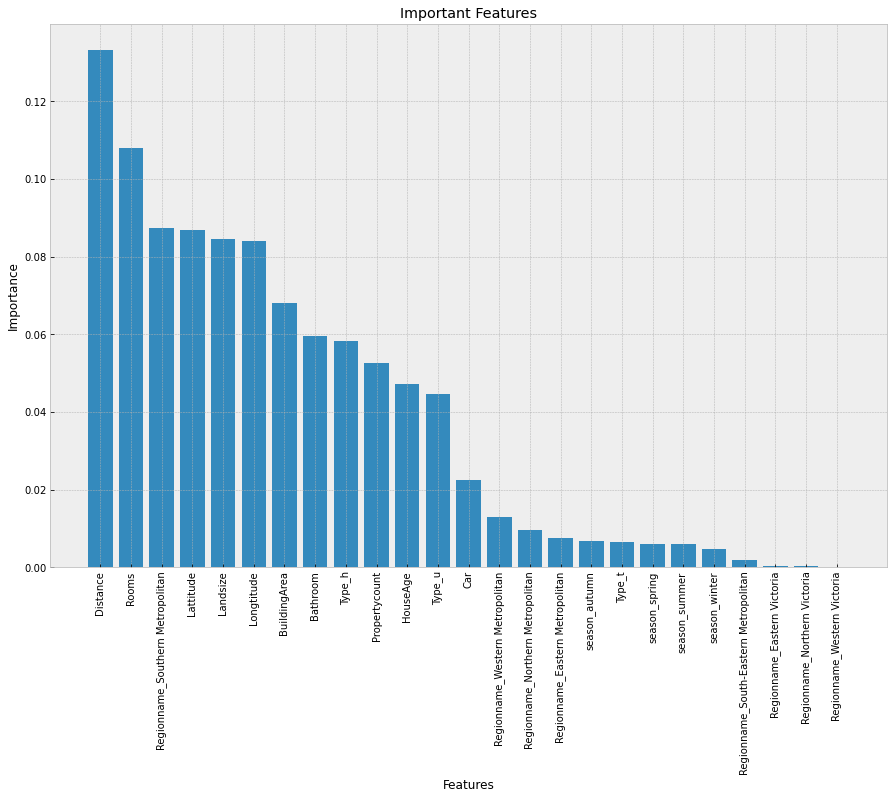

In [33]:
x_values = list(range(len(feature_importance)))

plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); 
plt.xlabel('Features'); 
plt.title('Important Features');

### Conclusion :

* The main feature that decides the price of a house is distance, which from the documentation we found out that it is the distance from nearest employment centers (offices)(in total 5). Next, 5 featues that plays a major role are Rooms, Longitude, Latitude, landsize and Southern Metropolitan Region, since we did onehot encode on categorical values, we were able to get this insight. Longitude and Latitude means geographical location which was expected, landsize and number of rooms. No brainer !

* The type of the house seems less important than these two categories, as houseAge and Type_h are respectively 10th and 11th in this ranking. Category Type_t (or townhouse) is the less relevant feature in this cluster.

* Date features (i.e. Year and the four seasons) are not that important, but in any case the year when the house was sold is slightly more important than the season.